# Capstone Project - The Battle of Neighborhoods

## Introduction

New York City, in the state of New York, is by far the largest city in the United States, with an estimated 2016 population of 8.55 million. The city features five separate boroughs: Staten Island, The Bronx, Brooklyn, Queens, and Manhattan. As many as 800 languages are spoken throughout New York City, making it the most diverse city in the world when it comes to linguistic multiplicity.

The estimated population for New York City in 2016 is 8,550,405. This reflects a growth of 375,300 people, a 4.6% increase since the 2010 census recorded 8.175 million residents.

The most significant increase in New York City’s population occurred in the borough of Brooklyn, which showed a population increase of 5.3% between the 2010 census and 2016 estimates. The second most substantial change is in the Bronx, which reflected a 5.1% increase, followed by Queens (4.9%), Manhattan (3.7%) and Staten Island (1.2%).

<b> According to the most recent ACS, the racial composition of New York City was </b>:
<ul>
    <li>White: 42.67%</li>
    <li>Black or African American: 24.27%</li>
    <li>Other race: 15.12%</li>
    <li>Asian: 13.95%</li>
    <li>Two or more races: 3.51%</li>
    <li>Native American: 0.43%</li>
    <li>Native Hawaiian or Pacific Islander: 0.05%</li>

This diversity in culture brings about diverse dishes. There are many resturants in New york City, each beloning to different categories like Spanish, Chinese , Indian , French etc.

So as part of this project , we will list and visualize all the parts of New York City that has great Mexican 
Resturants.

### Data 
For this project the following data are needed:
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Indian resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Mexican Resturants.
- Find rating , tips and like count for each Mexican Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is the best location in New York City for Mexican Dishes ? 
- Which areas have potential Mexican Resturant Market ? 
- Which all areas lack Mexican Resturants ?
- Which is the best place to stay if you prefer Mexican Dishes ?

### Analysis
We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [151]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [197]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [198]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [259]:
CLIENT_ID = 'UHS13L4TWFLNF5P32QP34V2B1AFZPTYU2ZISC5WA4MS3DA0U'
CLIENT_SECRET = 'S12WD1SPCKBOARHFRMNHU1JSFUHDOILVZJZXAP03U0Y4ZUMW'
VERSION = '20200130'

In [280]:
def get_venues(lat,lng):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [281]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the New york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [282]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [283]:
# get new york data
new_york_data=get_new_york_data()

In [284]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [285]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

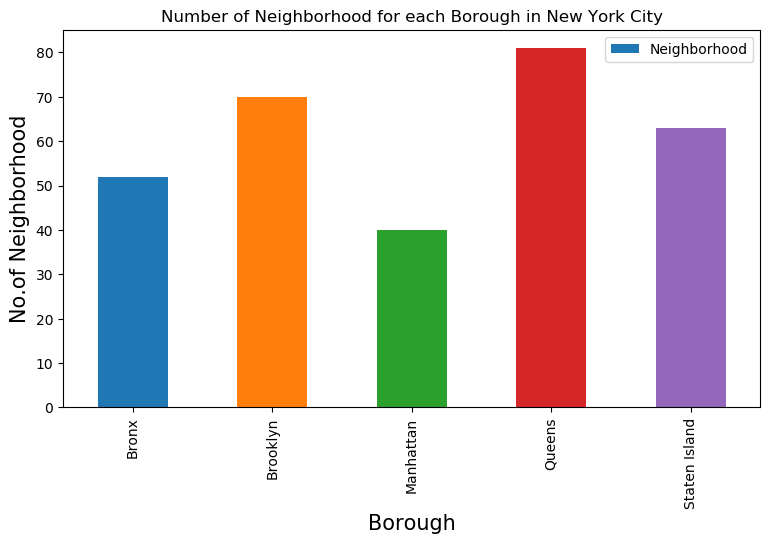

In [286]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Mexican resturants for each Neighborhood

In [287]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:0
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:0
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:0
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:3
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:1
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:1
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Mexican Resturants in City Island, Bronx:0
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:0
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Mexican Resturants in Fordham, Bronx:0
( 18 / 306 ) Mexican Resturants in East Tremont, Bronx:

( 141 / 306 ) Mexican Resturants in Sunnyside, Queens:1
( 142 / 306 ) Mexican Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Mexican Resturants in Maspeth, Queens:0
( 144 / 306 ) Mexican Resturants in Ridgewood, Queens:1
( 145 / 306 ) Mexican Resturants in Glendale, Queens:0
( 146 / 306 ) Mexican Resturants in Rego Park, Queens:0
( 147 / 306 ) Mexican Resturants in Woodhaven, Queens:0
( 148 / 306 ) Mexican Resturants in Ozone Park, Queens:0
( 149 / 306 ) Mexican Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Mexican Resturants in College Point, Queens:0
( 151 / 306 ) Mexican Resturants in Whitestone, Queens:0
( 152 / 306 ) Mexican Resturants in Bayside, Queens:2
( 153 / 306 ) Mexican Resturants in Auburndale, Queens:0
( 154 / 306 ) Mexican Resturants in Little Neck, Queens:0
( 155 / 306 ) Mexican Resturants in Douglaston, Queens:0
( 156 / 306 ) Mexican Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Mexican Resturants in Bellerose, Queens:0
( 158 / 306 ) Mexican Resturants

( 276 / 306 ) Mexican Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Mexican Resturants in Flatiron, Manhattan:0
( 278 / 306 ) Mexican Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Mexican Resturants in Blissville, Queens:0
( 280 / 306 ) Mexican Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Mexican Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Mexican Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Mexican Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Mexican Resturants in Dumbo, Brooklyn:1
( 285 / 306 ) Mexican Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Mexican Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Mexican Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Mexican Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Mexican Resturants in Roxbury, Queens:0
( 290 / 306 ) Mexican Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Mexican Resturants in Middle Village, Queens:0
( 292 / 306 ) Mexic

We have now gotten all the Mexican Restaurants in New York City. It now time to analyze the data.

In [290]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V
1,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant
2,Bronx,Kingsbridge,553d5376498e322eb4d37a1b,Chipotle Mexican Grill
3,Bronx,Norwood,4e74ebead1643f93b1b05d2c,Queen of Tacos
4,Bronx,Baychester,58582b156431e554e165d909,Moe's Southwest Grill


In [291]:
mexican_rest_ny.shape

(161, 4)

We have got 161 Spanish Restaurants in New York City

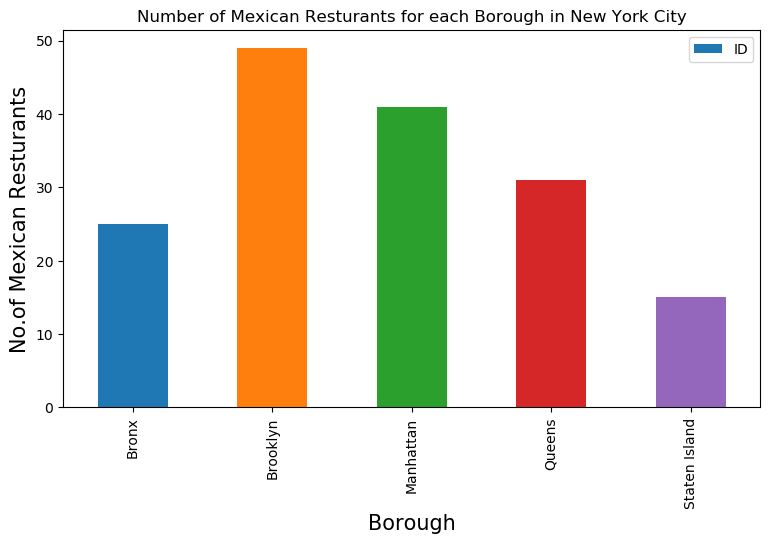

In [292]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Mexican Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Mexican Resturants', fontsize=15)
mexican_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

The above graph shows that we Brooklyn has the largest number of Spanish Resturants

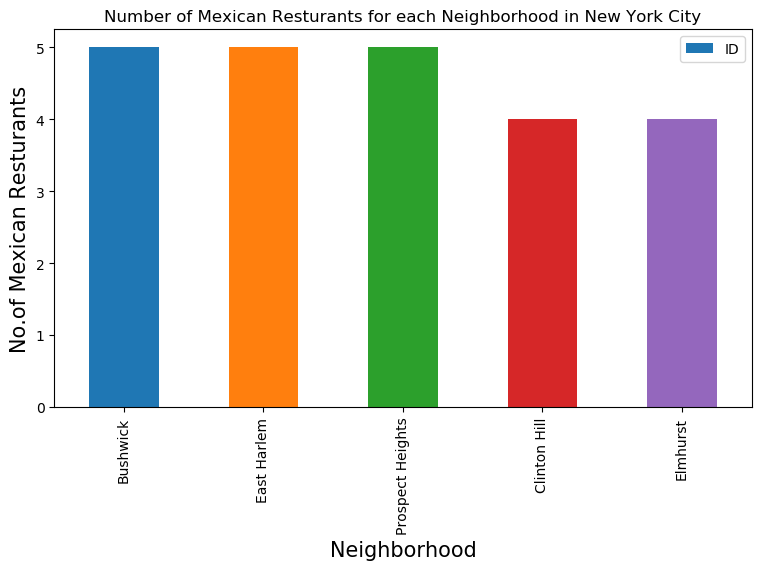

In [293]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Mexican Resturants', fontsize=15)
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

The above graph shows that Bushwick,East Harlem and Prospect Heights have the highest number of Mexican Restaurants with 5 restaurants each.
Let's take a look at the Restaurants in Bushwick

In [296]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Bushwick']

,Borough,Neighborhood,ID,Name
31,Brooklyn,Bushwick,507c9d44e4b07390823b8d98,Taqueria Sofia
32,Brooklyn,Bushwick,54a5a765498e6b7e2ce128c8,El Kucho
33,Brooklyn,Bushwick,4a79c17ef964a52093e71fe3,El Sol de Cholula
34,Brooklyn,Bushwick,571ac9ed498e4010d9d69e53,Taqueria Santa Fe
35,Brooklyn,Bushwick,4dd6d110814d85e931ff48e4,Zefe's Mexican Restaurant


Bushwick in Brooklyn a total of 5 Mexican Restaurants.

Now let's get the ranking of each resturant for further analysis.

In [297]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,ratings,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,ratings,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : ratings,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  5217dd2811d2d06ccafb77d3  Estrellita Poblana V     24     8.1     8
( 1 / 161 ) processed
                         ID                                Name  Likes  \
0  4ce81d330f196dcb5d2b43ae  Picante Picante Mexican Restaurant     19   

   Rating  Tips  
0     7.9    14  
( 2 / 161 ) processed
                         ID                    Name  Likes  Rating  Tips
0  553d5376498e322eb4d37a1b  Chipotle Mexican Grill     31     7.7     1
( 3 / 161 ) processed
                         ID            Name  Likes  Rating  Tips
0  4e74ebead1643f93b1b05d2c  Queen of Tacos      5     7.4     7
( 4 / 161 ) processed
                         ID                   Name  Likes  Rating  Tips
0  58582b156431e554e165d909  Moe's Southwest Grill      1     6.7     0
( 5 / 161 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4e4d0389bd413c4cc66dfd84  Las Maravillas De Mexico      6     7.2

                         ID           Name  Likes  Rating  Tips
0  59fbcf0a0457b7018e001f75  Tacos Project     22     7.5    11
( 54 / 161 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4a1b00edf964a520bb7a1fe3  Antojitos Mexicanos     12     7.6    13
( 55 / 161 ) processed
                         ID        Name  Likes  Rating  Tips
0  509d5ab2e4b029db3cfdced5  Pedro's II     12     5.9     5
( 56 / 161 ) processed
                         ID     Name  Likes  Rating  Tips
0  5db7884023aa41000849fc46  Tacombi     22     8.6     6
( 57 / 161 ) processed
                         ID                  Name  Likes  Rating  Tips
0  51c4c6de498edf95246e0072  Cerveceria Havemeyer    179     8.1    55
( 58 / 161 ) processed
                         ID                  Name  Likes  Rating  Tips
0  51c4c6de498edf95246e0072  Cerveceria Havemeyer    179     8.1    55
( 59 / 161 ) processed
                         ID     Name  Likes  Rating  Tips
0  5db7884023a

                         ID       Name  Likes  Rating  Tips
0  4f93adc2e4b08038d80dea72  Mi Cocina      1     7.0     4
( 105 / 161 ) processed
                         ID    Name  Likes  Rating  Tips
0  5a8eeaeff4b5255793fb12d3  Waheyo      9     8.3     3
( 106 / 161 ) processed
                         ID             Name  Likes  Rating  Tips
0  57f44dfa498e13c278fa4925  Gordo's Cantina     40     7.4    14
( 107 / 161 ) processed
                         ID                    Name  Likes  Rating  Tips
0  57f54617498e2cb89939bbfc  Chipotle Mexican Grill     31     8.2     5
( 108 / 161 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bd620d27b1876b033108c86  Momento     14     6.5     5
( 109 / 161 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c38e20aae2da593da8c01c6  Mi Nuevo Rancho      4     6.0     3
( 110 / 161 ) processed
                         ID              Name  Likes  Rating  Tips
0  51609091498eedc7cf34d817  

                         ID        Name  Likes  Rating  Tips
0  4e98cfecdab4e743aded173d  El Acatlan      6     7.2     3
( 158 / 161 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 509d404d498efdffc5ff1315
( 159 / 161 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4b403740f964a520e8b625e3  Montezuma Mexican Restaurant     27     6.8    21
( 160 / 161 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ee3f973f9abfc72263d490f
( 161 / 161 ) processed


In [298]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V,24,8.1,8
1,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant,19,7.9,14
2,Bronx,Kingsbridge,553d5376498e322eb4d37a1b,Chipotle Mexican Grill,31,7.7,1
3,Bronx,Norwood,4e74ebead1643f93b1b05d2c,Queen of Tacos,5,7.4,7
4,Bronx,Baychester,58582b156431e554e165d909,Moe's Southwest Grill,1,6.7,0


In [299]:
mexican_rest_stats_ny.shape

(161, 7)

In [300]:
mexican_rest_ny.shape

(161, 4)

Now let's save this data in a CSV file for each referrencing.

In [301]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv', index=False)

In [304]:
mexican_rest_stats_ny.shape

(161, 7)

In [305]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V,24,8.1,8
1,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant,19,7.9,14
2,Bronx,Kingsbridge,553d5376498e322eb4d37a1b,Chipotle Mexican Grill,31,7.7,1
3,Bronx,Norwood,4e74ebead1643f93b1b05d2c,Queen of Tacos,5,7.4,7
4,Bronx,Baychester,58582b156431e554e165d909,Moe's Southwest Grill,1,6.7,0


In [307]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 7 columns):
Borough         161 non-null object
Neighborhood    161 non-null object
ID              161 non-null object
Name            161 non-null object
Likes           161 non-null object
Rating          161 non-null float64
Tips            161 non-null object
dtypes: float64(1), object(6)
memory usage: 8.9+ KB


Let's convert the 'Likes' and 'Tips' to Float as they are currently in the String data type

In [308]:
mexican_rest_stats_ny['Likes']= mexican_rest_stats_ny['Likes'].astype('float64')
mexican_rest_stats_ny['Tips']= mexican_rest_stats_ny['Tips'].astype('float64')

In [309]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 7 columns):
Borough         161 non-null object
Neighborhood    161 non-null object
ID              161 non-null object
Name            161 non-null object
Likes           161 non-null float64
Rating          161 non-null float64
Tips            161 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.9+ KB


In [312]:
# Resturant with the Highest Likes
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood               Hunters Point
ID              4f62afe7e4b09b9cd8b354f6
Name                        Casa Enrique
Likes                                673
Rating                               9.1
Tips                                 231
Name: 145, dtype: object

In [313]:
# Resturant with the Highest Rating
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood               Hunters Point
ID              4f62afe7e4b09b9cd8b354f6
Name                        Casa Enrique
Likes                                673
Rating                               9.1
Tips                                 231
Name: 145, dtype: object

In [314]:
# Resturant with the Highest Tip
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood               Hunters Point
ID              4f62afe7e4b09b9cd8b354f6
Name                        Casa Enrique
Likes                                673
Rating                               9.1
Tips                                 231
Name: 145, dtype: object

Now lets look at the neighborhood with maximum average rating of Resturants.

In [315]:
neighborhood_stats = mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']

In [318]:
#These are the Neighborhood with the Highest Average Rating
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
46,Hunters Point,9.1
71,Parkchester,9.1
28,East Village,8.7
16,Chinatown,8.7
42,Greenpoint,8.7
78,Ridgewood,8.6
26,Dumbo,8.6
35,Fulton Ferry,8.6
90,Upper East Side,8.6
93,Westchester Square,8.5


In [319]:
borough_stats = mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']

# Average rating for each Borough
borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.839024
1,Brooklyn,7.014286
3,Queens,6.870968
0,Bronx,6.012000
4,Staten Island,5.166667


Now let us visualize this information

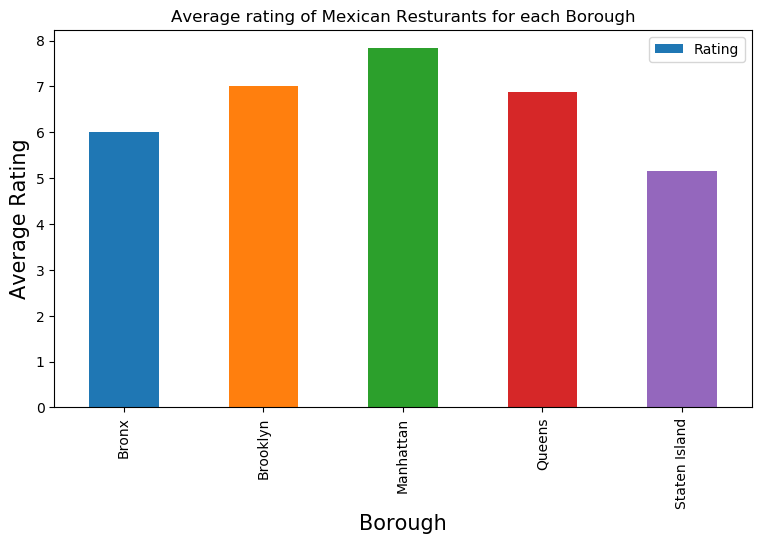

In [321]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Mexican Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

Now considering all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [322]:
neighborhood_stats= neighborhood_stats[neighborhood_stats['Average Rating']>=9.0]
neighborhood_stats

,Neighborhood,Average Rating
46,Hunters Point,9.1
71,Parkchester,9.1


let us join this dataset to original new york data to get lonitude and latitude

In [323]:
neighborhood_stats =pd.merge(neighborhood_stats,new_york_data, on='Neighborhood')
neighborhood_stats = neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Hunters Point,40.743414,-73.953868,9.1
1,Bronx,Parkchester,40.837938,-73.856003,9.1


Showing this data on a map

In [324]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [326]:

incidents = folium.map.FeatureGroup()

for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Adding a new field to dataframe for labeling purpose

In [329]:
neighborhood_stats['Label']= neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'

In [330]:
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [333]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'ny_geojson.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data= borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Please see the borough_rating file here: https://github.com/ufuomaolori/Coursera_Capstone/blob/master/borough_rating.html

### Conclusion 
- Queens(Hunters Point) and Bronx(Parkchester) are some of the best neighborhoods for Mexican Dishes. 
- Manhattan have potential Mexican Resturant Market.
- Staten Island	ranks last in average rating of Mexican Resturants.
- Manhattan is the best place to stay if you prefer Mexican Dishes.

### Limitations 
- The ranking is based on the rating of resturants
- The accuracy of data depends depends on the source of the data (FourSquare)